# Procedural example

Lookup tables in MyHDL can be translated to a [PMUX](pmux.ipynb) element, **if** only one wire of a wire set can be high at a time. When this is not the case, for instance during a glitch interval, the output is undefined/invalid.
If several conditions can be met (like when one condition would imply another one being met as well), we need to chain multiplexers in order to implement a priority selection.

In [1]:
import config

## Raw black box Muxer

To chain `$mux` elements, we use the code below to introduce the priority.

In [2]:
from myhdl import *
from myhdl._Signal import _Signal
from myhdl.conversion import yshelper

@blackbox
def mux_chain(select, choices, default, q):
    """Chained MUX logic"""
    
    width = len(q)
    
    @inference(yshelper.yosys)
    def implementation(module, interface):
        sel = interface.addPort("select")
        n = len(choices)
        if len(select) != n:
            raise ValueError("Mux select/choices mismatch!")
            
        y = interface.addPort('q', out = True)
        j = n - 1
        for i, sig in enumerate(reversed(choices)):    
            other = module.addSignal(None, width)

            s = sel.extract(j)
            if isinstance(sig, _Signal):
                drv = module.getCorrespondingWire(sig)
            else:
                drv = yshelper.ConstSignal(sig, width)
            module.addMux(yshelper.ID(__name__ + "mux%d" % j), other, drv, s, y)
            y = other # subsequent output to current 'other'
            j -= 1

        # Wire default signal
        if isinstance(default, _Signal):
            defsig = module.getCorrespondingWire(default)
        else:
            defsig = yshelper.ConstSignal(default, width) 

        module.connect(other, defsig)
    
    @always_comb
    def sim():
        "Simulation method for the above"
        q.next = default
        for i in range(len(select)):
            if select[i] == True:
                q.next = choices[i]
                break
                
    return sim, implementation

Then we create the following test scenario:
A selection table `SEL_TABLE` is used to create the `sel` signal and the choices tuple for creating the muxer chain. The first tuple in the entry defines a slice to be taken from a signal, compared against the second value in the tuple, when true, results in the third value being output. If none of the conditions is met, a default value needs to be passed to
the `mux_chain`.

In [3]:
@block
def isequal(a, b, q):
    @always_comb
    def worker():
        q.next = a == b
    return instances()

@block
def test1(clk, reset, val, q, MODE = 1):
    r = Signal(bool())

    SEL_TABLE = (
       ( (5, 0), 0, 3 ),
       ( (4, 0), 0, 2 ),
       ( (3, 0), 0, 1 ),
       ( (2, 0), 0, 0 ),
    )
    
    table = SEL_TABLE
    N = len(table)

    select = [ Signal(bool()) for e in SEL_TABLE ]
    
    sel = ConcatSignal(*reversed(select))
    choices = tuple( e[2] for e in table )
    # Take slices from val:
    values = [ val(e[0][0], e[0][1]) for e in SEL_TABLE ]
    # Careful: passing the concatsignal directly to a @block call
    # can be broken in some releases.
    inst_mc = mux_chain(sel, choices, 0xff, q)
    
    if MODE == 0:
        comp = [ e[1] for e in table ]
    else:
        comp = tuple( e[1] for e in table )

    inst = []
    # Procedural generation of comparators:
    for i in range(N):
        inst.append(isequal(choices[i], values[i], select[i]))

    return instances()

Test bench, the `@blackbox` way:

In [4]:
class MyImpl(yshelper.Implementation):
    """Test implementation"""

@blackbox
def test_design(unit):
    """A test design (virtual board)"""
    clk = Signal(bool(0))
    op = Signal(intbv()[16:])
    z = Signal(intbv()[5:])
    
    reset = ResetSignal(1, 1, True)

    inst_unit = unit(clk, reset, op, z)
    
    def convert(design):
        inst_unit.convert("yosys_module", design, name="unit")
    
    @inference(MyImpl)
    def rtl(design, top_name):
        convert(design)
        
        return design
        
    @instance
    def startup():
        yield delay(40)
        reset.next = 0

    @always(delay(2))
    def clkgen():
        clk.next = not clk

    return instances(), rtl

### Synthesis

In [5]:
impl = test_design(test1)
design = impl.implement("rtl", "unit")

Implementation: Test implementation
	Infer blackbox: 'mux_chain_0_0'
Adding module with name: mux_chain_4_4_c255_5
ConcatSignal 'select': 4 signals
Adding module with name: isequal_c3_5_1
CONVERT_RTL tree >>>>>> 'UNIT_ISEQUAL_0_WORKER' 
Adding module with name: isequal_c2_4_1
CONVERT_RTL tree >>>>>> 'UNIT_ISEQUAL_1_WORKER' 
Adding module with name: isequal_c1_3_1
CONVERT_RTL tree >>>>>> 'UNIT_ISEQUAL_2_WORKER' 
Adding module with name: isequal_c0_2_1
CONVERT_RTL tree >>>>>> 'UNIT_ISEQUAL_3_WORKER' 
Adding module with name: test1_1_1_16_5
ConcatSignal 'sel': 4 signals
========== Unroll slices for val/unit_val ===========
unit_val[5:0]
unit_val[4:0]
unit_val[3:0]
unit_val[2:0]
No ID for slice4, assign 'unit_val[5:0]'
unit_val[5:0]
No ID for slice5, assign 'unit_val[4:0]'
unit_val[4:0]
No ID for slice6, assign 'unit_val[3:0]'
unit_val[3:0]
No ID for slice7, assign 'unit_val[2:0]'
unit_val[2:0]
Get Concat signal isequal_0_q
Get Concat signal isequal_1_q
Get Concat signal isequal_2_q
Get Co

## Muxer chain RTL display

Generating RTL image...
Display...


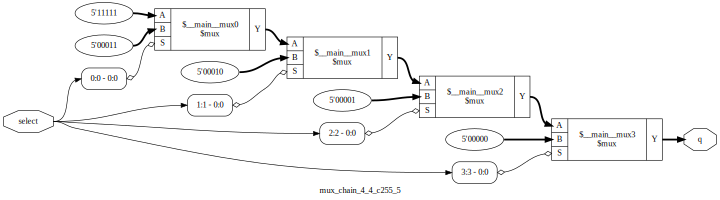

In [6]:
import sys
sys.path.append("..")
from ys_aux import to_svg
design.run("opt")
display(to_svg(design, 'mux_chain_4_4_c255_5'))

## Full design (flattened)

To see the entire design, we optimize away some buffers and flatten:

In [7]:
design.run("opt; flatten;")
display(to_svg(design, 'test1_1_1_16_5', 150))

Generating RTL image...
Display...
